# Quasar or galaxy?

#### Tasks

The dataset is at `solutions/galaxyquasar.csv` (I extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))

- First, read the datafile.
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

##### Food for thought
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?


### Exploring data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
data = np.genfromtxt('galaxyquasar.csv', delimiter=',', dtype = str)

In [3]:
print(data)

[['u' 'g' 'r' ... 'class' 'z1' 'zerr']
 ['18.97213' '18.53676' '18.5828' ... 'QSO' '0.5228189' '0.0001547483']
 ['19.24592' '17.47646' '16.47817' ... 'GALAXY' '0.1228459'
  '2.816076E-05']
 ...
 ['18.62718' '17.30876' '16.87371' ... 'GALAXY' '0.05442934'
  '8.433598E-06']
 ['19.5514' '18.27711' '17.62101' ... 'GALAXY' '0.1125709' '9.286238E-06']
 ['18.80772' '17.75751' '17.405' ... 'GALAXY' '0.04365238' '7.415751E-06']]


In [4]:
#collecting data
u = data[1:,0].astype('float64')
g = data[1:,1].astype('float64')
r = data[1:,2].astype('float64')
i = data[1:,3].astype('float64')
z = data[1:,4].astype('float64')

r_i = r-i
i_z = i-z
u_g = u-g
g_r = g-r

#assigning 0 to galaxies 1 otherwise
labels = data[1:,5]
labels = np.where(labels=='GALAXY',0,1)

Let's explore data: since I want to try classification algorithms with different data dimension I would like to understand which of the measured features are the most important. To do so I tried to scatter plot two features at a time to see which ones are displaying a larger distance between the two classes, then I analysed the distribution of one feature at a time, separating quasars from galaxies.

Text(0.5, 1.0, 'Two components')

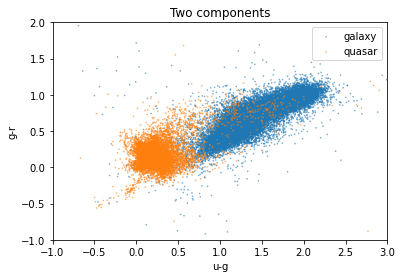

In [5]:
#scattering two features
fig, ax = plt.subplots(1,1, figsize=(6,4))
colors = np.where(labels==0, 'tab:blue', 'tab:orange')
ax.scatter(u_g[labels==0], g_r[labels==0], color = colors[labels==0], s=0.5, alpha=0.5, label='galaxy')
ax.scatter(u_g[labels==1], g_r[labels==1], color = colors[labels==1], s=0.5, alpha=0.5, label='quasar')
ax.legend()

ax.set_ylim(-1,2)
ax.set_xlim(-1,3)
ax.set_xlabel('u-g')
ax.set_ylabel('g-r')
ax.set_title('Two components')

Text(0.5, 0.98, 'Features distribution')

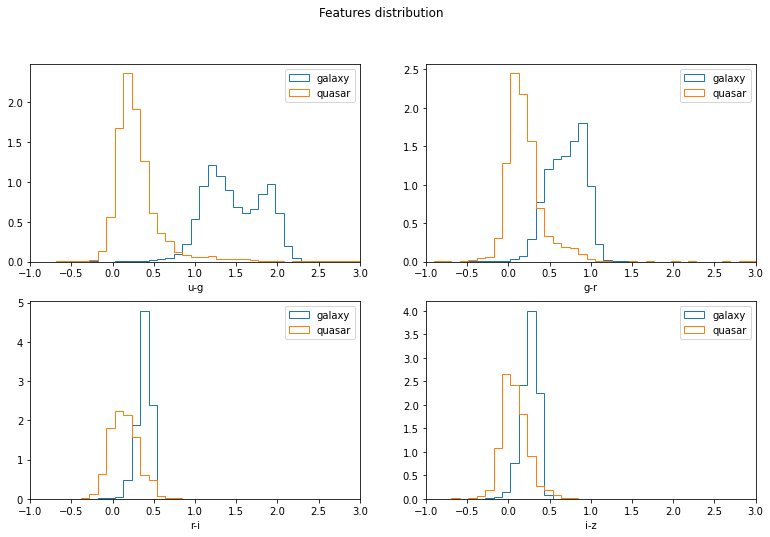

In [6]:
#one component at a time
color_diff = np.array([u_g, g_r, r_i, i_z])

fig, ax = plt.subplots(2,2, figsize=(13, 8))
ax = ax.reshape(4)

names = ['u-g', 'g-r', 'r-i', 'i-z']

for i in range(len(ax)):
    ax[i].hist(color_diff[i][labels==0], histtype='step', bins=np.linspace(-1,3, 40), density=True, label='galaxy')
    ax[i].hist(color_diff[i][labels==1], histtype='step', bins=np.linspace(-1,3, 40), density=True, label='quasar')
    ax[i].legend()
    ax[i].set_xlim(-1,3)
    ax[i].set_xlabel(names[i])
    
plt.suptitle('Features distribution')

From the histograms above you see that the highest bimodality is shown by the $u-g$ feature, that will therefore represent the first component where to apply classification algorithms, followed by $g-r$, $r-i$, $i-z$ that are going to be added one at a time.

### Splitting data

Since we have labels on all our data, we can split the set into train and test set, so that from the study of the train set we are going to predict labels on the test set.

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(color_diff.T, labels, test_size=0.25, random_state=25)

### Classification

The function below can be used with any type of classification algorithm.

In [8]:
from astroML.utils import split_samples
from sklearn.metrics import roc_curve
from astroML.utils import completeness_contamination


def useful_function(color_diff, labels, *args):  #color_diff [KxN], labels [N], classifier and args if needed
    y_pred=[[] for i in range(4)]
    y_prob = [[] for i in range(4)]

    completeness = [[] for i in range(4)]
    contamination = [[] for i in range(4)]
    fpr = [[] for i in range(4)]
    tpr = [[] for i in range(4)]
    thresh = [[] for i in range(4)]

    
    #with this for cycle we include one more component each time
    for i in range(4):
        clas = args[0][0](**args[0][1])
        clas.fit(x_train[:,:i+1], y_train)
        y_pred[i] = clas.predict(x_test[:,:i+1]) #predicted labels for the test set (i = ndim_used -1)
        y_prob[i] = clas.predict_proba(x_test[:,:i+1])[:,1] #predicted probability for each test sample of being a quasar 
    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_prob[i]) #roc curve

        completeness[i], contamination[i] = completeness_contamination(y_pred[i], y_test) #completeness contamination
    
        #decision boundary in two dimensions
        if i==1:
            xlim = (-1, 3)
            ylim = (-1, 3)
            xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 80), np.linspace(ylim[0], ylim[1], 80))
            Z = clas.predict_proba(np.c_[xx.ravel(), yy.ravel()]) #predicting prob at each point of the grid
            Z = Z[:, 1].reshape(xx.shape)

    for i in range(4):
        fpr[i] = np.concatenate([[0], fpr[i]])
        tpr[i] = np.concatenate([[0], tpr[i]])
    
    return y_pred, y_prob, completeness, contamination, fpr, tpr, Z


### GaussianNB, LDA, QDA

In [9]:
#GaussianNB
from sklearn.naive_bayes import GaussianNB
y_pred_gnb, y_prob_gnb, completeness_gnb, contamination_gnb, fpr_gnb, tpr_gnb, z_gnb= useful_function(color_diff, labels, (GaussianNB, {}))
print('GaussianNB : done')

#LDA
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
y_pred_lda, y_prob_lda, completeness_lda, contamination_lda, fpr_lda, tpr_lda, z_lda = useful_function(color_diff, labels, (LinearDiscriminantAnalysis, {}))
print('LDA : done')

#QDA
y_pred_qda, y_prob_qda, completeness_qda, contamination_qda, fpr_qda, tpr_qda, z_qda = useful_function(color_diff, labels, (QuadraticDiscriminantAnalysis, {}))
print('QDA : done')

GaussianNB : done
LDA : done
QDA : done


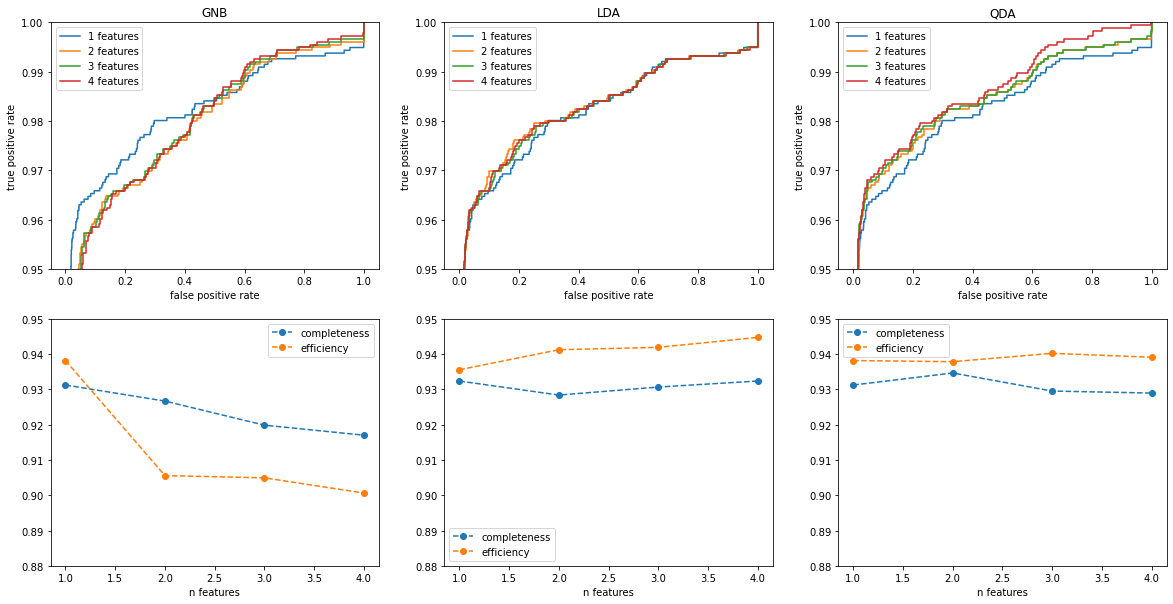

In [10]:
fig, ax = plt.subplots(2,3, figsize=(20, 10))
ax=ax.reshape(6)

for i in range(len(fpr_gnb)):
    ax[0].plot(fpr_gnb[i], tpr_gnb[i], label='%.0f features' %(i+1))
    ax[0].set_title('GNB')
    ax[1].plot(fpr_lda[i], tpr_lda[i], label='%.0f features' %(i+1))
    ax[1].set_title('LDA')
    ax[2].plot(fpr_qda[i], tpr_qda[i], label='%.0f features' %(i+1))
    ax[2].set_title('QDA')

n_dim = [1,2,3,4]
ax[3].plot(n_dim, completeness_gnb, c='tab:blue', marker='o', ls='--', label='completeness')
ax[3].plot(n_dim, 1-np.array(contamination_gnb), c='tab:orange', marker='o', ls='--', label='efficiency')

ax[4].plot(n_dim, completeness_lda, c='tab:blue', marker='o', ls='--', label='completeness')
ax[4].plot(n_dim, 1-np.array(contamination_lda), c='tab:orange', marker='o', ls='--', label='efficiency')

ax[5].plot(n_dim, completeness_qda, c='tab:blue', marker='o', ls='--', label='completeness')
ax[5].plot(n_dim, 1-np.array(contamination_qda), c='tab:orange', marker='o', ls='--', label='efficiency')

for j in ax[:3]:   
    j.set_ylim(0.95, 1) 
    j.legend()
    j.set_ylabel('true positive rate')
    j.set_xlabel('false positive rate')
    
for j in ax[3:]:
    j.set_xlabel('n features')
    j.legend()
    j.set_ylim(0.88, 0.95)


All three methods seem to do a really good job in classifing quasars as we can see from the ROC curves that are reaching high values of true positive rate ($\sim 0.97$) for very low false positive rates. 

Gaussian Naive Bayes method: the algorithm seems to be highly performant when we have just one feature as the area of the blue ROC curve is the highest. Even in the plot below you see that adding features in this case is just adding noise as the efficiency goes down because of high rates of TypeI errors.

LDA: there's no much difference in the performance of the algorithm as the number of features changes, so the optimal number of dimensions is highly depending on the goals of the research. For example if the aim is to correctly classify the highest number of quasars it could be useful working with data such that the completeness is maximised, but if we prefer to have low level of contamination we could choose to analyse all the 4 components.

QDA: the algorithm does a really good job when considering all the 4 features, as the ROC curve suggests. It seems to be the best algrithm to use if compared to the previous two, hinting to the existence of a covariance between features which is different for the two classes.

In general completeness with these three algorithms is more or less of the same order but if you are looking for a model with low levels of contamination at a high number of features maybe GNB is not the best.

### GMMBayes and KNeighborsClassifier

Since in GMMBayes the distribution of each class is seen as a Gaussian Mixture we have a hyperparameter to tune (n_components). So first I run a cross validation process to find the best number of gaussian components then I use it to classify samples. The same thing is done for KN, where the hyperparameter to tune is the number of neighbors.

In general I would need to implement a cv procedure 4 times, because for example the suitable number of neighbors to consider when we have 1 feature in our data could be different from the same value when we are considering 4 features of our data. The process is however really computationally expensive, therefore here I just implemented a cross-validation considering all four features and using the resulting optimal value for the fit. Of course in this case it is possible that when we are considering all the 4 dimensions our results will be better, since we are optimizing the hyperparameters of the algorithm with four dimensional data.

In [22]:
#MIND THE COMPUTER COULD EXPLODE
#GMMBayes
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from astroML.classification import GMMBayes

#cross validation to get the optimal number of gaussian components
n_range=np.linspace(1, 25, 25).astype(int)
print(n_range)
scores=[]

for k in n_range:
    clf = GMMBayes(n_components=k)
    CVpredk = cross_val_predict(clf, x_train, y_train, cv=10)
    scores.append(accuracy_score(y_train, CVpredk)) 


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]


The maximum accuracy in 4 dimensions requires:  25  components


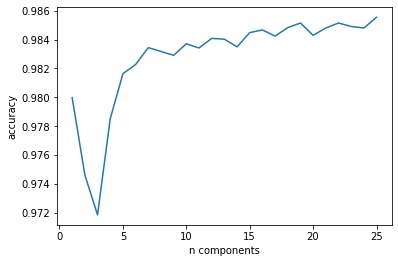

In [42]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(n_range, scores)
ax.set_xlabel('n components')
ax.set_ylabel('accuracy')
print('The maximum accuracy in 4 dimensions requires: ',np.argmax(scores)+1, ' components')

Here you see that the accuracy is increasing as the number of components is increasing, however after 15 components the values seem to oscillate around the same mean, which is about 0.985. Since the gain in accuracy is not that high I prefer to use a more simple model with 15 gaussian components.

In [35]:
y_pred_gmmb, y_prob_gmmb, completeness_gmmb, contamination_gmmb, fpr_gmmb, tpr_gmmb, z_gmmb = useful_function(color_diff, labels,(GMMBayes, dict(n_components=15)))
print('GMMBayes : done')

GMMBayes : done


In [25]:
from sklearn.neighbors import KNeighborsClassifier

#cross validation to get the optimal number of neighbors
k_range=np.linspace(2, 25, 24).astype(int)
print(k_range)
scores_k=[]

for k in k_range:
    clf = KNeighborsClassifier(n_neighbors=k)
    CVpredk = cross_val_predict(clf, x_train, y_train, cv=10)
    scores_k.append(accuracy_score(y_train, CVpredk)) 

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]


The maximum accuracy for 4 components is achieved requiring:  8  neighbors


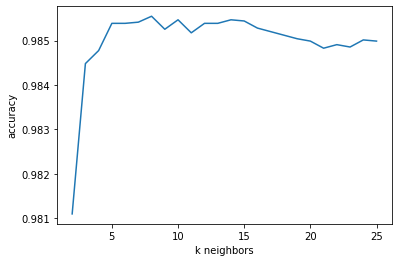

In [26]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(k_range, scores_k)
ax.set_xlabel('k neighbors')
ax.set_ylabel('accuracy')
print('The maximum accuracy for 4 components is achieved requiring: ', np.argmax(scores_k)+2, ' neighbors')

Here the optimal number of neighbors is definitely around 8 because adding more points will cause the accuracy to decrease.

In [27]:
#Kneighbors
from sklearn.neighbors import KNeighborsClassifier
y_pred_knn, y_prob_knn, completeness_knn, contamination_knn, fpr_knn, tpr_knn, z_knn = useful_function(color_diff, labels, (KNeighborsClassifier, dict(n_neighbors=np.argmax(scores_k)+2)))
print('KNN : done')

KNN : done


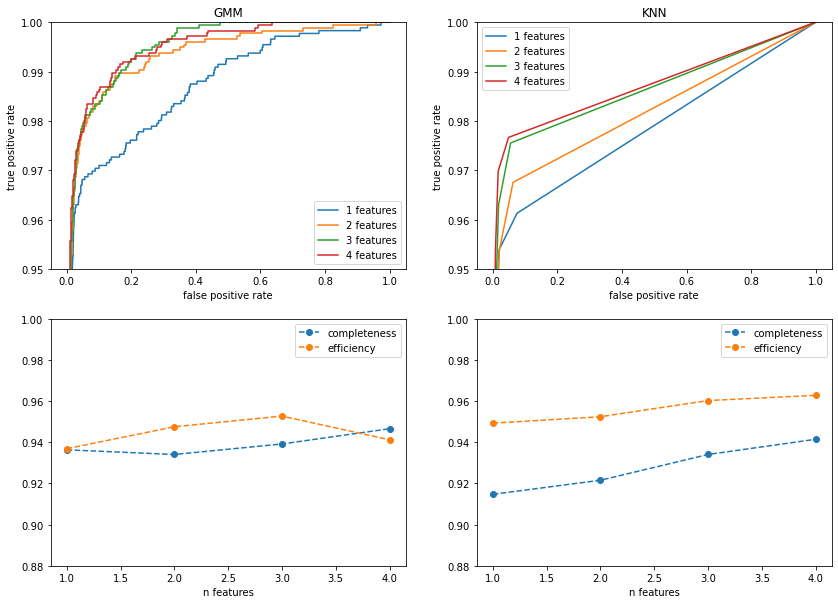

In [36]:
fig, ax = plt.subplots(2,2,figsize=(14, 10))
ax=ax.reshape(4)
for i in range(len(fpr_gnb)):
    ax[0].plot(fpr_gmmb[i], tpr_gmmb[i], label='%.0f features' %(i+1))
    ax[0].set_title('GMM')
    ax[1].plot(fpr_knn[i], tpr_knn[i], label='%.0f features' %(i+1))
    ax[1].set_title('KNN')

n_dim = [1,2,3,4]
ax[2].plot(n_dim, completeness_gmmb, c='tab:blue', marker='o', ls='--', label='completeness')
ax[2].plot(n_dim, 1-np.array(contamination_gmmb), c='tab:orange', marker='o', ls='--', label='efficiency')

ax[3].plot(n_dim, completeness_knn, c='tab:blue', marker='o', ls='--', label='completeness')
ax[3].plot(n_dim, 1-np.array(contamination_knn), c='tab:orange', marker='o', ls='--', label='efficiency')

for j in ax[:2]:   
    j.set_ylim(0.95, 1) 
    j.legend()
    j.set_ylabel('true positive rate')
    j.set_xlabel('false positive rate')
    
for j in ax[2:]:
    j.set_xlabel('n features')
    j.legend()
    j.set_ylim(0.88, 1)


These two algorithms are doing a really good job! The GMM ROC reaches very high value of true positive rate at low false positive rate when the observed features are 3 or 4. And look at the completeness when we have 4 features: it goes up above 0.94. This is probably one of the best results so far. For KNN we could probably see the effects of cv implementation on 4-dim data since both efficiency and completeness are increasing with more dimensions.

### Visualizing results

Let's use GMM classification to compare predicted labels to the true ones. Here I show a histogrm of the more significant feature $u-g$.

Text(0.5, 0, 'u-g')

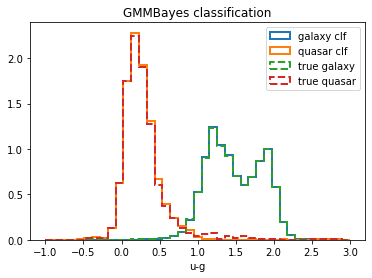

In [39]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.hist(x_test[:,0][y_pred_gmmb[-1]==0], bins=np.linspace(-1,3, 40), density=True, histtype='step', label='galaxy clf', lw=2)
ax.hist(x_test[:,0][y_pred_gmmb[-1]==1], bins=np.linspace(-1,3,40), density=True, histtype='step', label='quasar clf', lw=2)

ax.hist(x_test[:,0][y_test==0], bins=np.linspace(-1,3, 40), density=True, histtype='step', label='true galaxy', ls='--', lw=2)
ax.hist(x_test[:,0][y_test==1], bins=np.linspace(-1,3,40), density=True, histtype='step', label='true quasar', ls='--', lw=2)

ax.legend()
ax.set_title('GMMBayes classification')
ax.set_xlabel('u-g')

Certainly some galaxies with high $u-g$ are classified as quasars, so there's some contamination present, but the re-created distribution is really similar to the original one!

We can also visualize decision boundaries. Here I plot as a black line the contour plot of the function that is mapping the probability of finding a quasar in this 2-d space, selecting the value of 0.5.

(6,)


Text(0.5, 1.0, 'KNN')

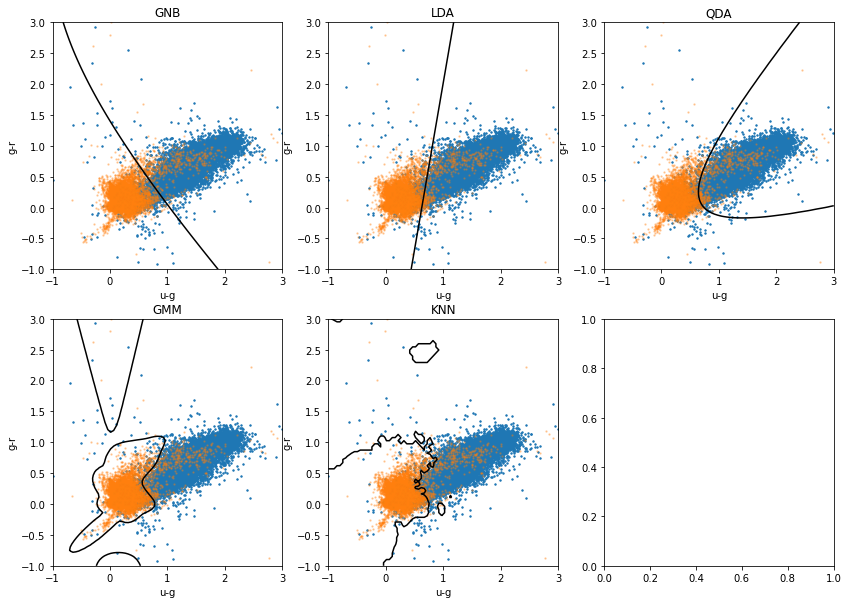

In [41]:
#decision boundary
fig, ax = plt.subplots(2,3, figsize=(14,10))
ax = ax.reshape(-1)
print(ax.shape)

xlim=(-1,3)
ylim=(-1,3)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 80), np.linspace(ylim[0], ylim[1], 80))
z = [z_gnb, z_lda, z_qda, z_gmmb, z_knn]

for i in range(len(ax)-1):
    ax[i].scatter(u_g[labels==0], g_r[labels==0], s=2)
    ax[i].scatter(u_g[labels==1], g_r[labels==1], s=2, alpha=0.3)
    ax[i].set_ylim(-1,3)
    ax[i].set_xlim(-1,3)
    ax[i].contour(xx,yy,z[i],[0.5], colors='k') #plotting the line embedding the area where the probability 
                                                #of finding a quasar is 0.5
    ax[i].set_xlabel('u-g')
    ax[i].set_ylabel('g-r')
ax[0].set_title('GNB')
ax[1].set_title('LDA')
ax[2].set_title('QDA')
ax[3].set_title('GMM')
ax[4].set_title('KNN')